# [Машинное обучение на ФБМФ](https://thetahat.ru/courses/bm-2025-spr)

## Решающие деревья

Цель этого ноутбука &mdash; знакомство с решающими деревьями, с их параметрами и свойствами. В ноутбуке рассмотрены примеры применения решающих деревьев для решения задач классификации и регрессии.

In [2]:
import numpy as np
import pandas as pd
import scipy.stats
import warnings
import graphviz
from tqdm import tqdm_notebook

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import tree

sns.set(font_scale=1.5)
warnings.filterwarnings("ignore")

### 1. Решающие деревья в задаче классификации

Для начала рассмотрим задачу классификации на простом датасете, состоящем только из двух признаков. Это сделает удобным процесс визуализации решающего дерева. Для генерации такого простого датасета воспользуемся методом <a href="https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html" target="_blank">`make_classification`</a> модуля `sklearn.datasets`.

#### Генерация данных

Основные аргументы функции:
* `n_samples` &mdash; размер выборки;
* `n_features` &mdash; количество признаков всего (кроме целевого);
* `n_informative` &mdash; количество "информативных"признаков, от которых непосредственно зависит целевой признак;
* `n_classes` &mdash; количество классов;
* `n_redundant` &mdash; количество "лишних" признаков, не оказывающих воздействие на целевой.

In [3]:
data, target = datasets.make_classification(
    n_samples=100, n_features=2, n_informative=2, n_classes=3, 
    n_redundant=0, n_clusters_per_class=1, random_state=3
)

data.shape, target.shape

((100, 2), (100,))

Сопоставим каждому классу цвет

In [4]:
colors = ListedColormap(['#FF3300', '#0099CC', '#00CC66'])
light_colors = ListedColormap(['lightcoral', 'lightblue', 'lightgreen'])

Посмотрим на данные.

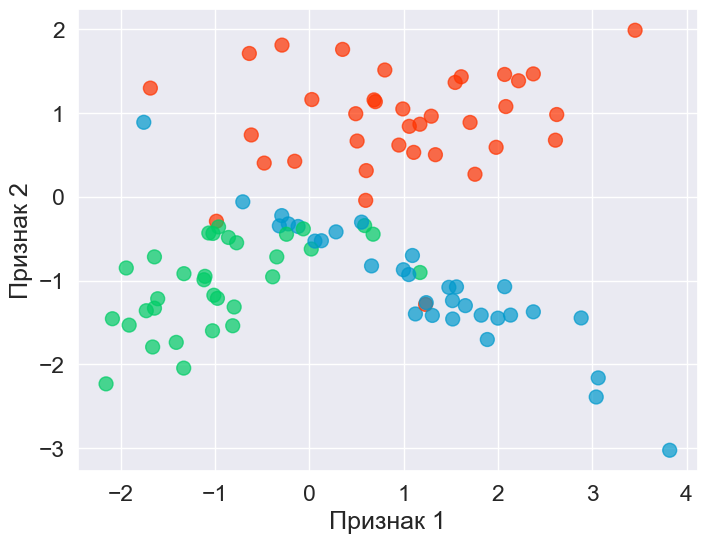

In [5]:
plt.figure(figsize=(8, 6))
grid_x1 = data[:, 0]
grid_x2 = data[:, 1]
plt.scatter(grid_x1, grid_x2, c=target, cmap=colors, s=100, alpha=0.7)
plt.xlabel('Признак 1'), plt.ylabel('Признак 2');

Разобьём данные на обучающую и валидационную выборки.

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(
    data, target, test_size=0.3, random_state=777
)

Инициализируем и обучим решающее дерево для классификации с помощью <a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html" target="_blank">`DecisionTreeClassifier`</a>. Общий интерфейс класса аналогичен классу `LinearRegression`, который мы подробно разбирали <a href="https://miptstats.github.io/courses/ad_fivt/linreg_sklearn.html" target="_blank">ранее</a>. Гиперпараметры дерева мы разберем далее.

In [7]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

Посчитаем предсказания дерева и посчитаем точность полученной классификации. Точность классификации вычисляется как *доля правильно предсказанных классов*.

In [8]:
predictions = clf.predict(X_valid)
accuracy_score(y_valid, predictions)

0.9

Неплохой результат. Но на таком простом датасете могло быть и лучше.

#### Визуализация решающей поверхности (decision surface)

При использовании решающего дерева в простых задачах, где в данных один или два признака, бывает полезно посмотреть на разделяющую поверхность. По виду разделяющей поверхности можно получить представление, действительно ли дерево улавливает важные закономерности в данных и не возникло ли переобучения. Если данные имеют большое число признаков, то визуализировать разделяющую поверхность довольно сложно. Но в нашем случае (в данных ровно два признака) всё достаточно просто.

In [9]:
def get_meshgrid(data, step=.05, border=.5):
    '''
    Функция для получения сетки точек (x1, x2) 
    для дальнейшего отображения их на графиках
    
    Параметры:
    1) data - входной датасет, набор точек (x1_i, x2_i);
    2) step - мелкость сетки;
    3) border - отступ от минимальных и максимальных значений x1, x2 в data 
    в сетке
    '''
    
    x1_min, x1_max = data[:, 0].min() - border, data[:, 0].max() + border
    x2_min, x2_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x1_min, x1_max, step), 
                       np.arange(x2_min, x2_max, step))

In [10]:
def plot_decision_surface(
    estimator, X_train, y_train, X_valid, y_valid, colors=colors, 
    light_colors=light_colors, title='', metric=accuracy_score
):
    '''
    Функция для отображения разделяющей поверхности классификатора
    
    Параметры:
    1) estimator - классификатор;
    2) X_train, y_train - данные и разметка обучающей выборки;
    3) X_valid, y_valid - данные и разметка валидационной выборки;
    4) colors - цвета для отображения точек из разных классов;
    5) light_colors - цветовая схема для отображения разделяющей поверхности;
    6) title - заголовок графика.
    7) metric - метрика качества классификации.
    '''
    
    estimator.fit(X_train, y_train)  # обучаем модель
    
    plt.figure(figsize=(16, 6))
    
    # отображаем разделяющую поверхность и точки обучающей выборки
    plt.subplot(1,2,1)
    x1_values, x2_values = get_meshgrid(X_train)
    x1_ravel, x2_ravel = x1_values.ravel(), x2_values.ravel()
    mesh_predictions_ravel = estimator.predict(np.c_[x1_ravel, x2_ravel])
    mesh_predictions = np.array(mesh_predictions_ravel).reshape(x1_values.shape)
    
    plt.grid(False)
    plt.pcolormesh(x1_values, x2_values, mesh_predictions, cmap=light_colors)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, 
                s=100, cmap=colors, edgecolors='black')
    plt.xlabel('Признак 1'), plt.ylabel('Признак 2')
    plt.title('Обуч. выборка, {}={:.2f}'.format(
        metric.__name__,metric(y_train, estimator.predict(X_train))
    ))
    
    # отображаем разделяющую поверхность и точки валидационной выборки
    plt.subplot(1,2,2)
    plt.grid(False)
    plt.pcolormesh(x1_values, x2_values, mesh_predictions, cmap=light_colors)
    plt.scatter(X_valid[:, 0], X_valid[:, 1], c=y_valid, 
                s=100, cmap=colors, edgecolors='black')
    plt.title('Валид. выборка, {}={:.2f}'.format(
        metric.__name__, metric(y_valid, estimator.predict(X_valid))
    ))
    plt.xlabel('Признак 1'), plt.ylabel('Признак 2')
    plt.suptitle(title, fontsize=20)

#### Визуализация разделяющей поверхности при изменении параметра `max_depth`

Посмотрим, как будет меняться разделяющая поверхность при изменении значения параметра `max_depth`.

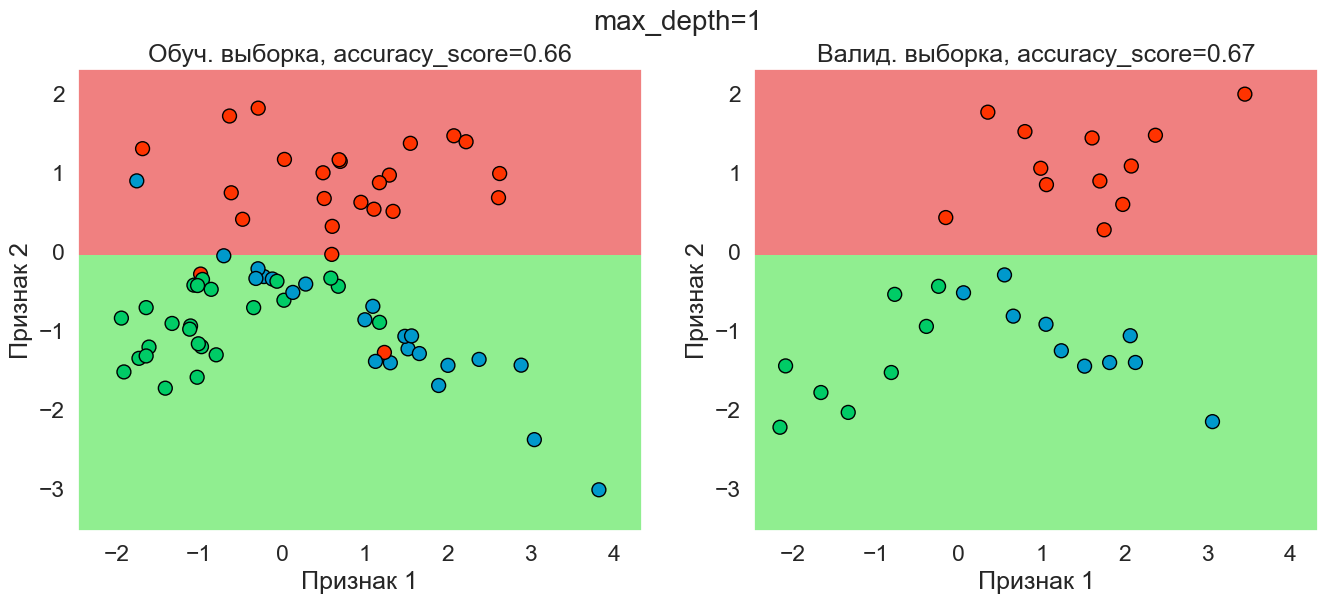

In [11]:
estimator = DecisionTreeClassifier(random_state=42, max_depth=1)
plot_decision_surface(
    estimator, X_train, y_train, 
    X_valid, y_valid, title='max_depth=1'
)

Разделяющая поверхность оказалась довольно простой. Ведь если глубина дерева равна одному, то в нём происходит разделение выборки ровно по одному признаку. 

Несложно заметить, что если в датасете для классификации $k$ классов, то необходимо брать дерево с глубиной не менее $\log_2 k$, так как мы хотим, чтобы в полученном дереве было не менее $k$ листьев. Иначе дерево будет предсказывать $< k$ классов, чего мы хотим избежать.


Попробуем увеличить максимальную глубину дерева.

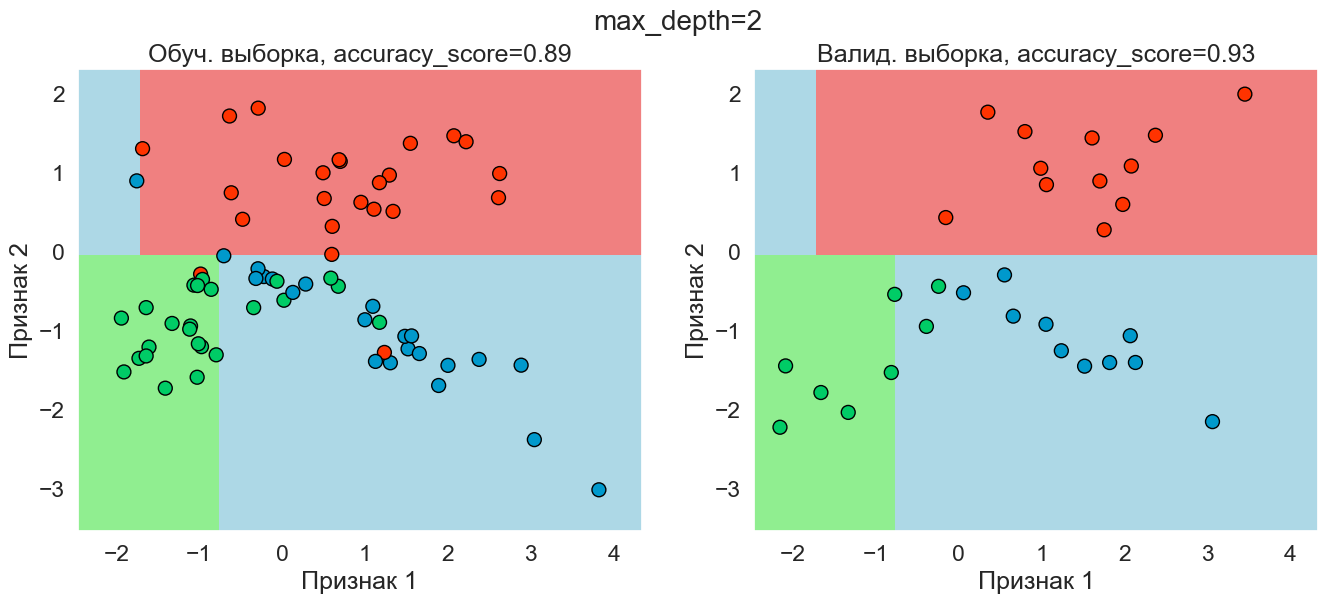

In [12]:
estimator = DecisionTreeClassifier(random_state=42, max_depth=2)
plot_decision_surface(
    estimator, X_train, y_train, 
    X_valid, y_valid, title='max_depth=2'
)

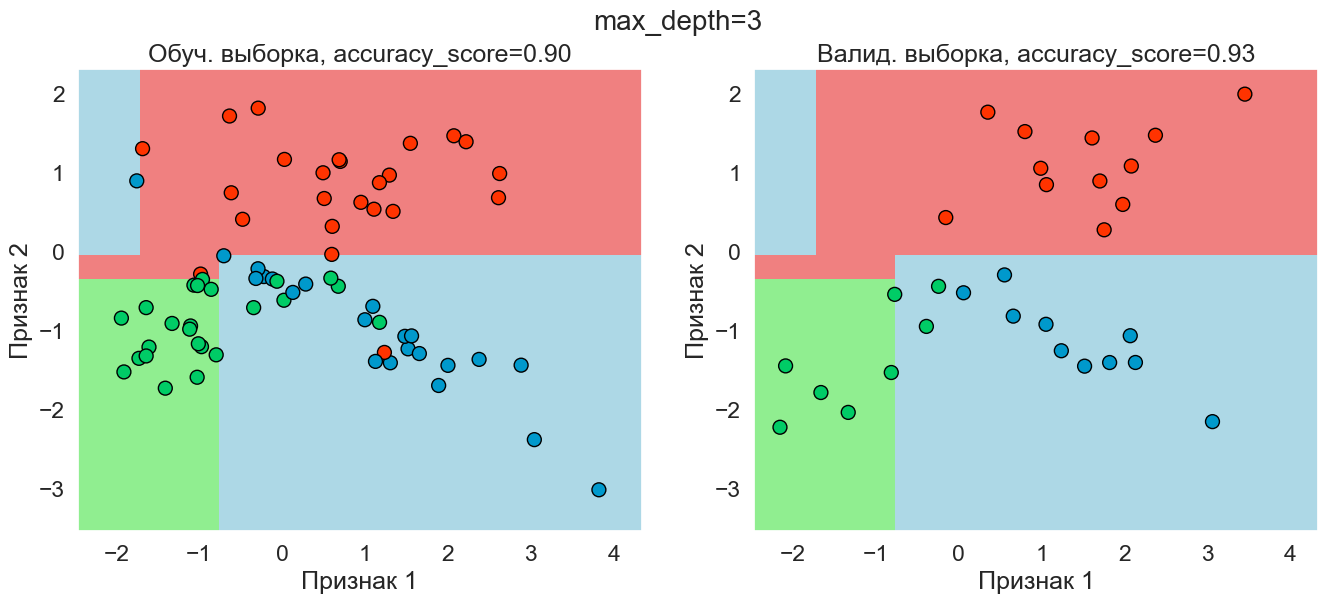

In [13]:
estimator = DecisionTreeClassifier(random_state=42, max_depth=3)
plot_decision_surface(
    estimator, X_train, y_train, 
    X_valid, y_valid, title='max_depth=3'
)

Заметим, что сложность разделяющей поверхности заметно увеличилась. Точность предсказания дерева заметно возросла. 

А теперь посмотрим, что произойдёт, если резко увеличить значение параметра `max_depth`.

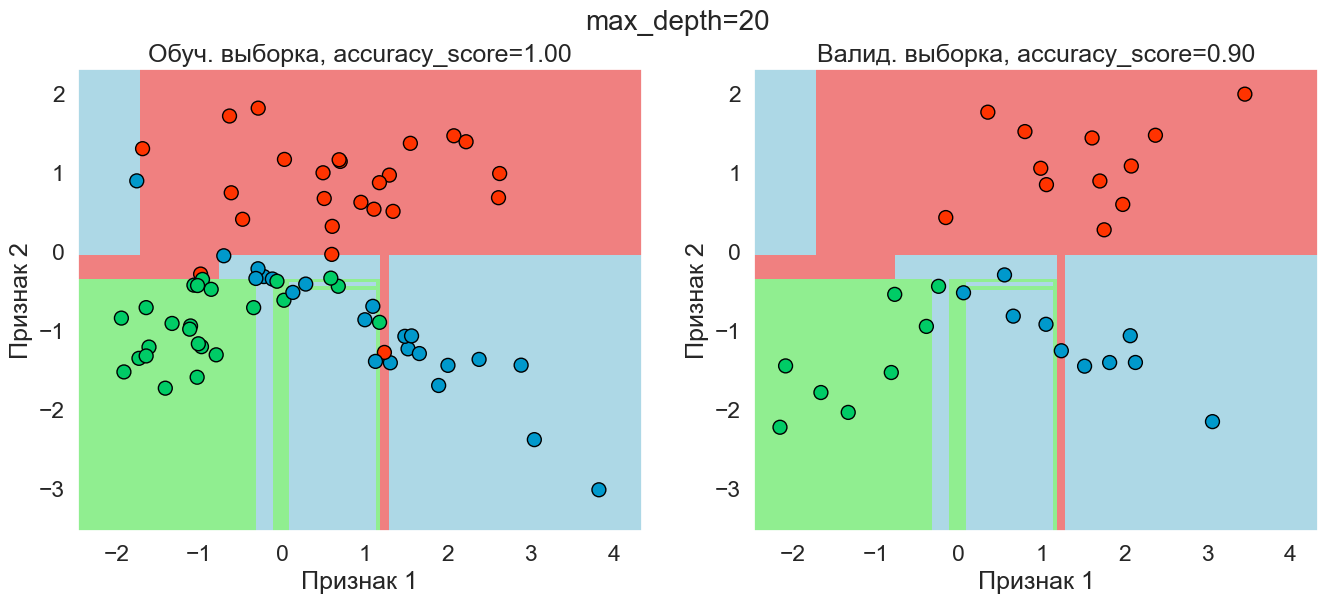

In [14]:
estimator = DecisionTreeClassifier(random_state=42, max_depth=20)
plot_decision_surface(
    estimator, X_train, y_train, 
    X_valid, y_valid, title='max_depth=20'
)


Заметим, что accuracy на обучающей выборке стало равно единице, а на валидационной выборке стало хуже, чем при максимальной возможной глубине, равной трем. Это означает, что произошло **переобучение дерева**. Этот пример демонстрирует проявление на практике следующих свойств решающих деревьев:

1. Решающие деревья очень легко могут быть переобучены, причём склонность к переобучению возрастает с возрастанием глубины дерева.
2. Для любой выборки для классификации существует решающее дерево, идеально восстанавливающее истинный отклик.

**Вывод.**

Как правило, 
* увеличение значения параметра `max_depth` приводит к увеличению точности классификации на обучающей выборке, 
* но с некоторого момента увеличение значения `max_depth` приводит к ухудшению точности на валидационной выборке, так как начинается стадия переобучения.

#### Визуализация разделяющей поверхности при изменении параметра `min_samples_leaf`

Другим важным параметром решающего дерева является `min_samples_leaf` &mdash; минимальное количество элементов выборки, которые могут находиться в листовой вершине дерева. При разбиении вершины дерева проверяется, что после разбиения количество элементов выборки, находящихся как в левой, так и в правой дочерних вершинах не меньше `min_samples_leaf`. Если это условие не выполняется, то такое разбиение отвергается.

Такое условие необходимо для того, чтобы предсказание для данного листа было достаточно устойчиво. Например, если попал только один объект, то предсказание для данного листа будет равно таргету данного объекта, что является достаточно шумным предсказанием, а если попало 5 объектов, то предсказание будет более устойчиво к шуму и выбросам. Кроме того, без ограничения возможна ситуация, при которой один объект может определить метку для большой области в пространстве, находясь при этом на границе этой области.

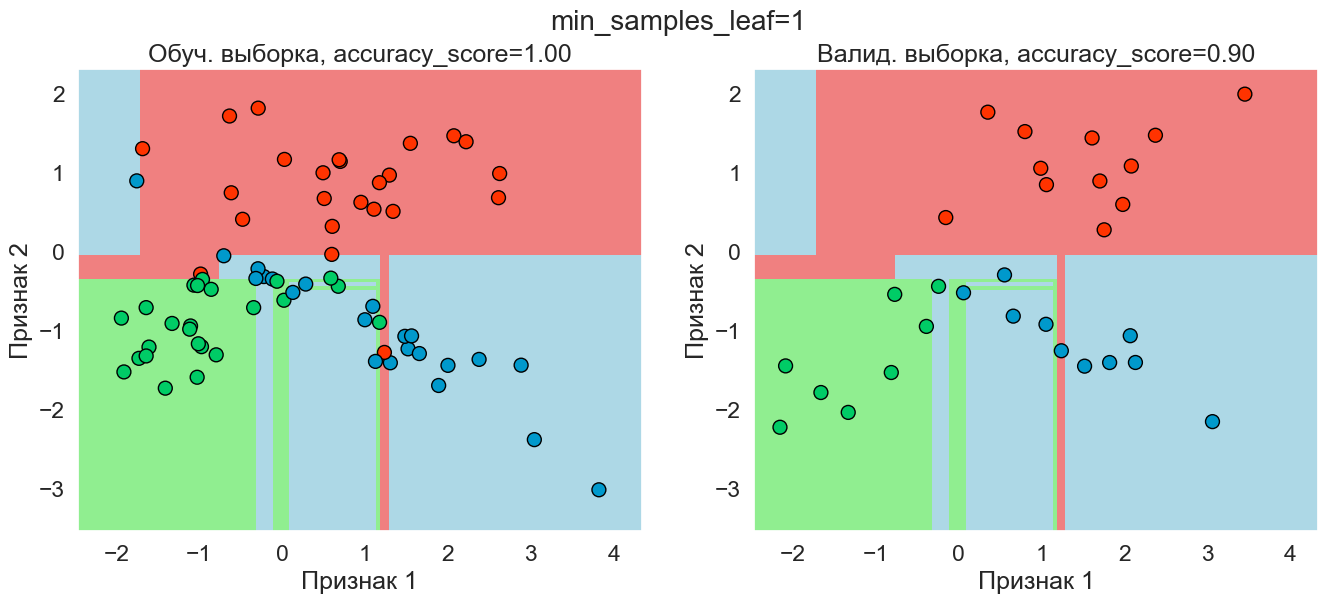

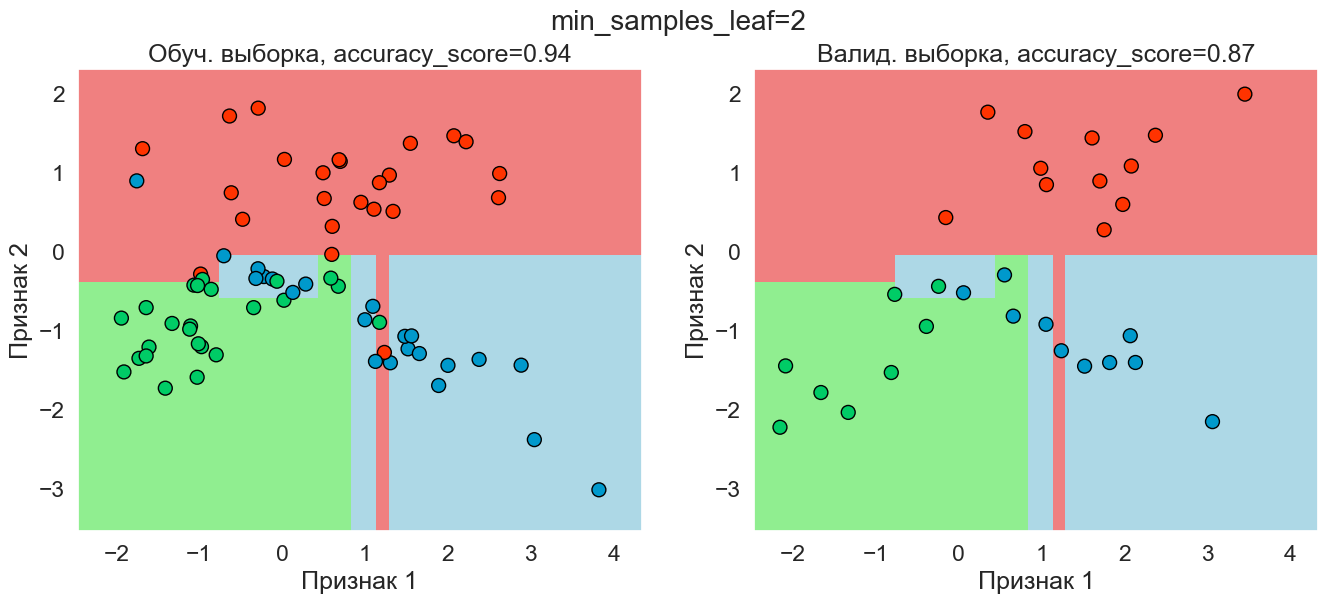

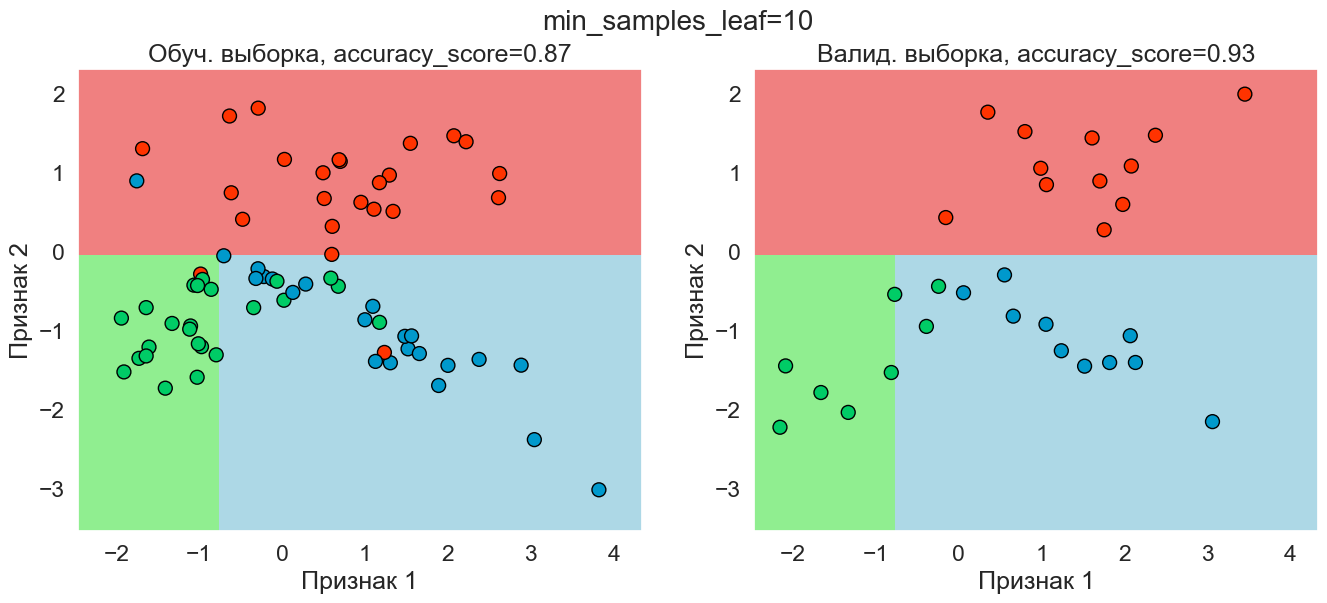

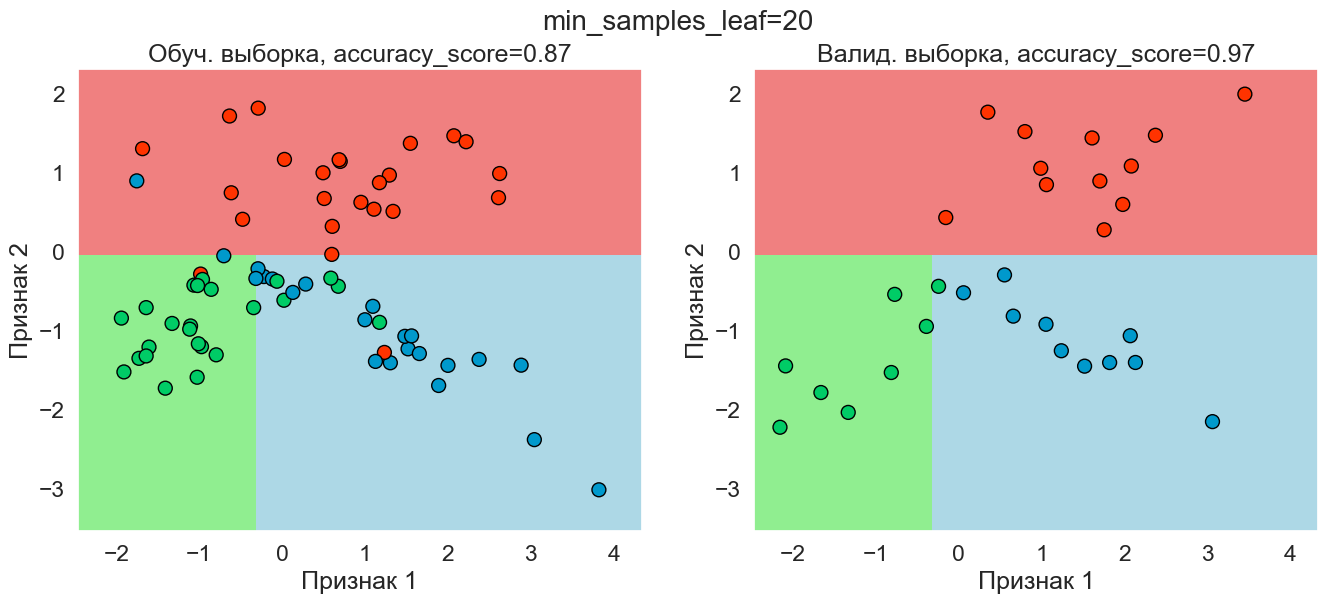

In [15]:
for min_samples_leaf in [1, 2, 10, 20]:
    estimator = DecisionTreeClassifier(
        random_state=42, min_samples_leaf=min_samples_leaf
    )
    plot_decision_surface(
        estimator, X_train, y_train, X_valid, y_valid, 
        title=f'min_samples_leaf={min_samples_leaf}'
    )

Построим график зависимости accuracy от `min_samples_leaf` на обучающей и на валидационной выборках.

In [16]:
def get_train_and_valid_accuracy(param_name, grid):
    '''
    Функция для оценки точности классификации 
    для заданных значений параметра param_name
    
    Параметры:
    1) param_name - название параметра, который собираемся варьировать,
    2) grid - сетка значений параметра
    '''
        
    train_acc, valid_acc = [], []
    
    for param_value in grid:
        estimator = DecisionTreeClassifier(**{param_name: param_value})
        estimator.fit(X_train, y_train)
        train_acc.append(accuracy_score(y_train, estimator.predict(X_train)))
        valid_acc.append(accuracy_score(y_valid, estimator.predict(X_valid)))
    return train_acc, valid_acc

In [17]:
def plot_dependence(param_name, grid=range(2, 20), title=''):
    '''
    Функция для отображения графика зависимости accuracy 
    от значения параметра c названием param_name
    
    Параметры:
    1) param_name - название параметра, который собираемся варьировать,
    2) grid - сетка значений параметра,
    3) title - заголовок графика
    '''
    
    plt.figure(figsize=(12, 6))
    
    train_acc, valid_acc = get_train_and_valid_accuracy(param_name, grid)
        
    plt.plot(grid, train_acc, label='train', lw=3)
    plt.plot(grid, valid_acc, label='valid', lw=3)
    plt.legend(fontsize=14)
    plt.xlabel(param_name)
    plt.ylabel('Точность классификации')
    plt.title(title, fontsize=20)
    plt.show()

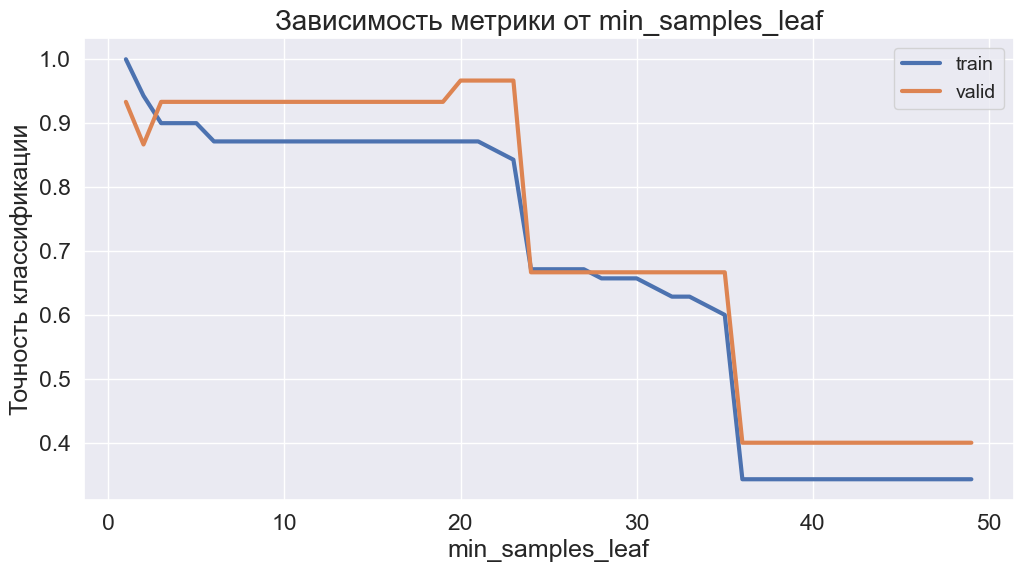

In [18]:
plot_dependence(
    'min_samples_leaf', range(1, 50), 
    title='Зависимость метрики от min_samples_leaf'
)

**Вывод.**

В целом наблюдается следующая закономерность. С увеличением значения `min_samples_leaf` качество 
* на обучающей выборке падает, 
* на валидационной выборке сначала возрастает, а затем начинает убывать. 

Получается, увеличение значения параметра `min_samples_leaf` &mdash; один из способов борьбы с переобучением при использовании решающих деревьев.

Но, всё же, стоит заметить, что повышение значения `min_samples_leaf` делает разделяющую поверхность проще. Значит, при слишком больших значениях `min_samples_leaf` модель становится слишком простой и перестаёт улавливать закономерности из данных.

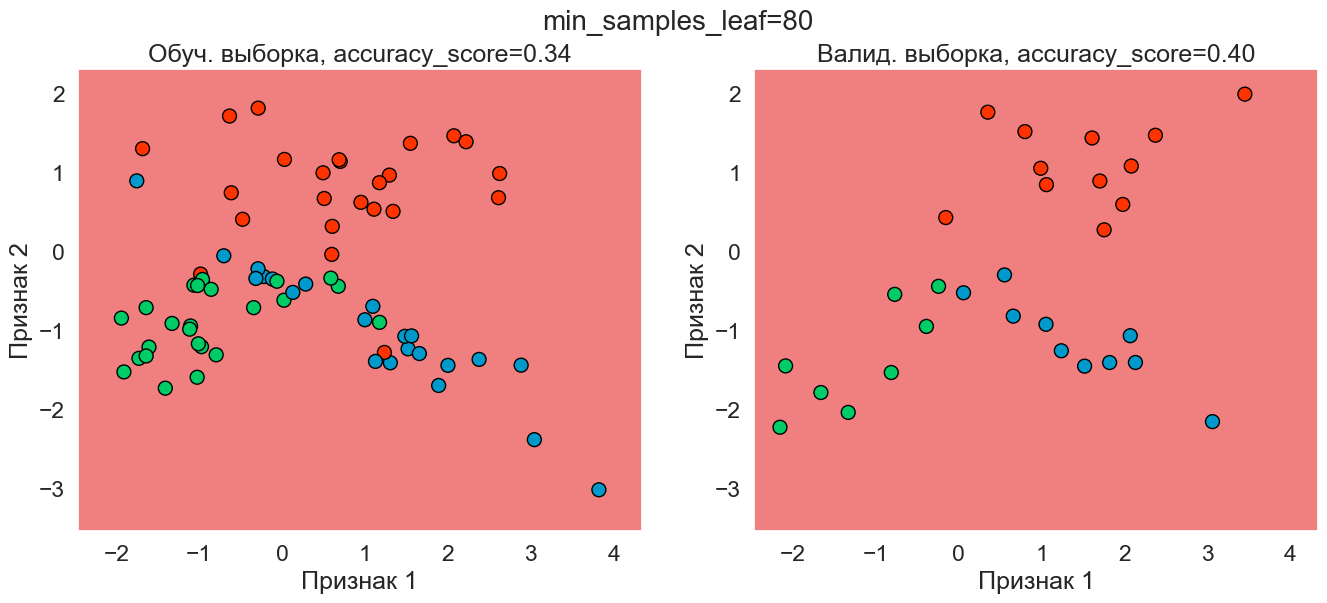

In [19]:
estimator = DecisionTreeClassifier(
    random_state=42, min_samples_leaf=80
)
plot_decision_surface(
    estimator, X_train, y_train, 
    X_valid, y_valid, title='min_samples_leaf=80'
)

Здесь мы привели пример решающего дерева при использовании `min_samples_leaf=80`.

#### Визуализация разделяющей поверхности при изменении параметра `min_samples_split`

Последний параметр, который мы будем подробно визуализировать &mdash; `min_samples_split`, минимальное количество элементов, которое должно попасть в вершину, чтобы её можно было делить. 

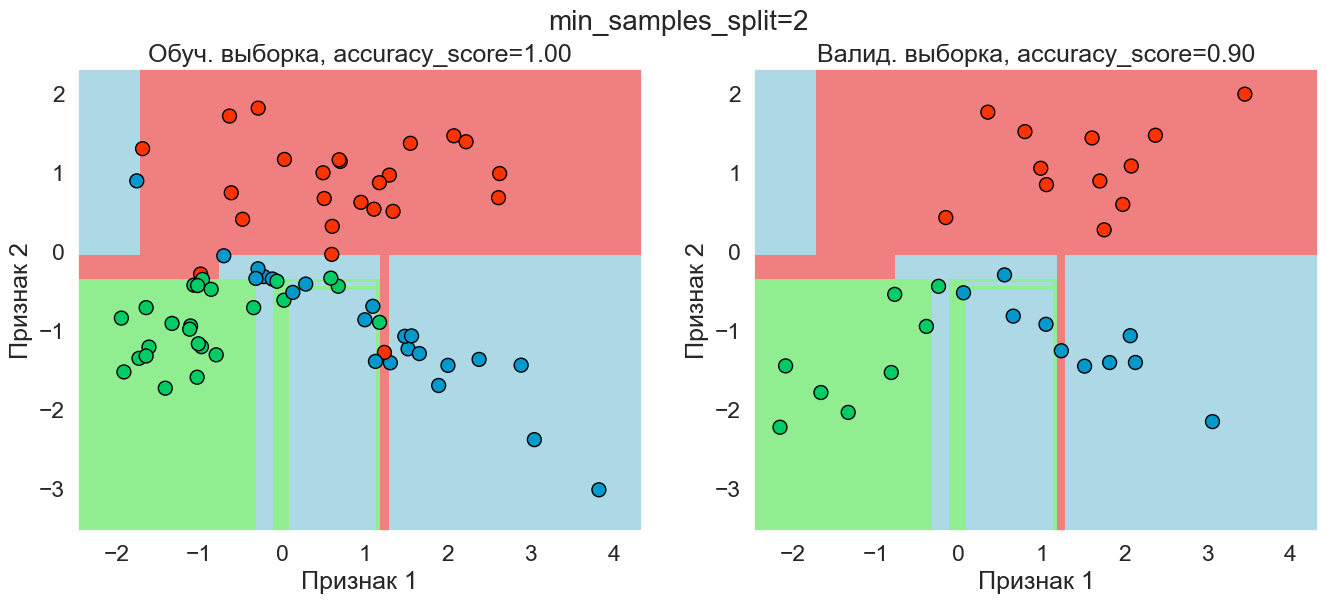

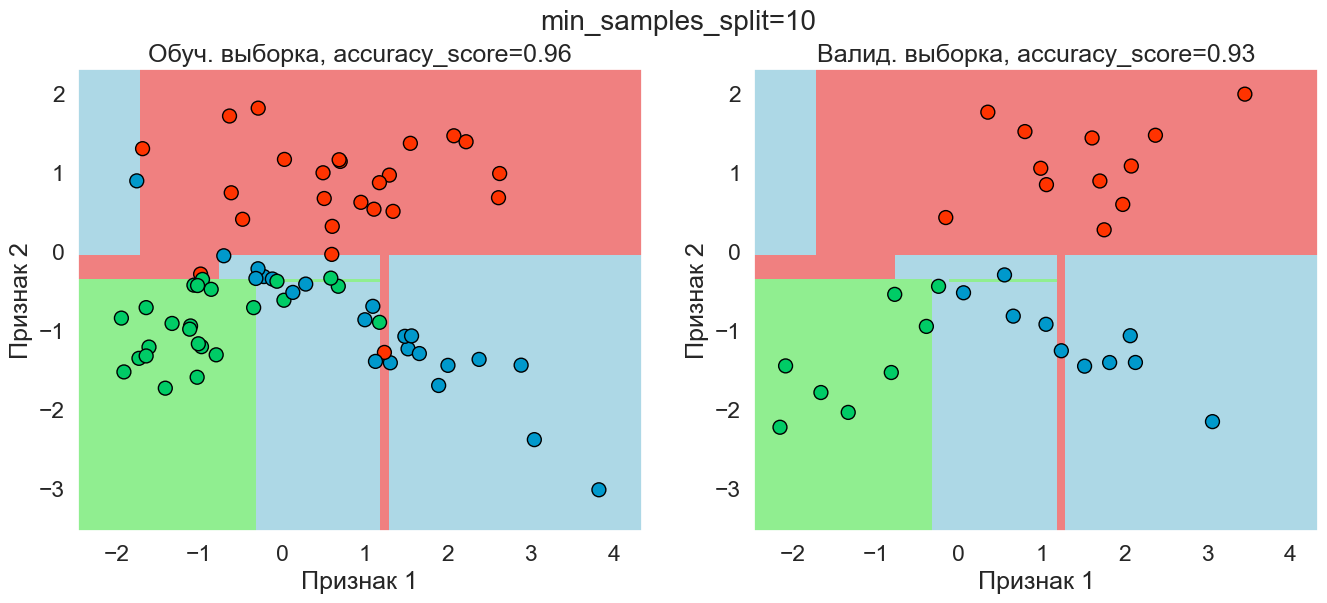

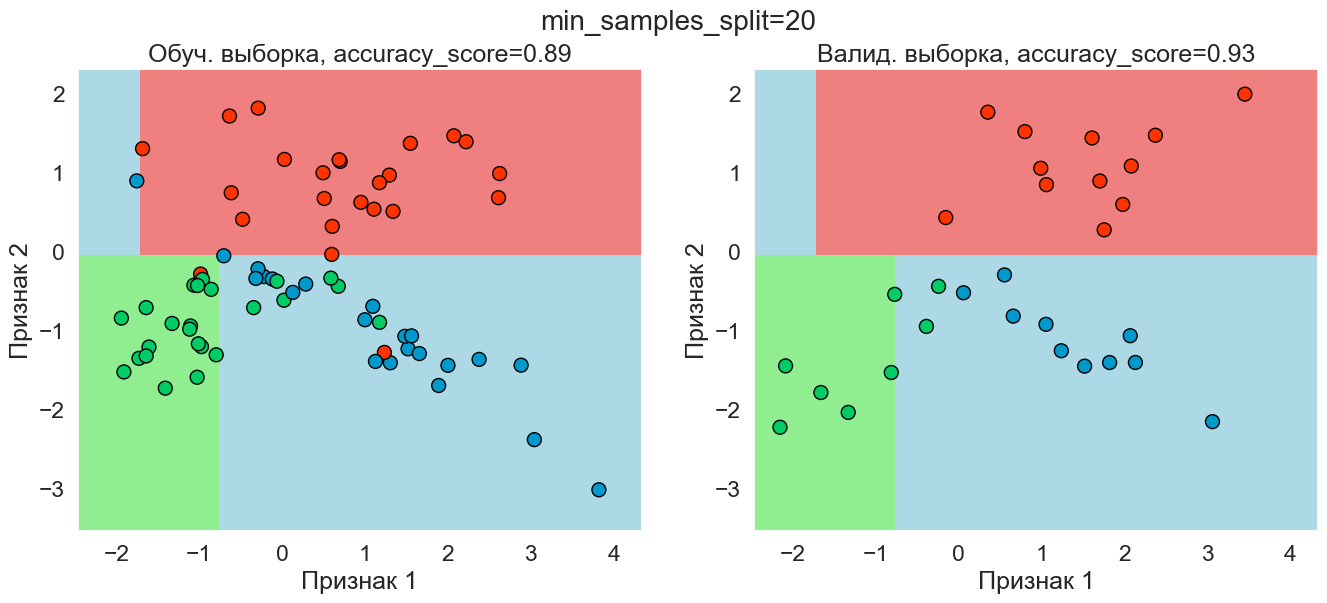

In [20]:
for min_samples_split in [2, 10, 20]:
    estimator = DecisionTreeClassifier(
        random_state=42, min_samples_leaf=1,
        min_samples_split=min_samples_split
    )
    plot_decision_surface(
        estimator, X_train, y_train, X_valid, y_valid, 
        title=f'min_samples_split={min_samples_split}'
    )

А теперь попробуем резко увеличить значение `min_samples_split`.

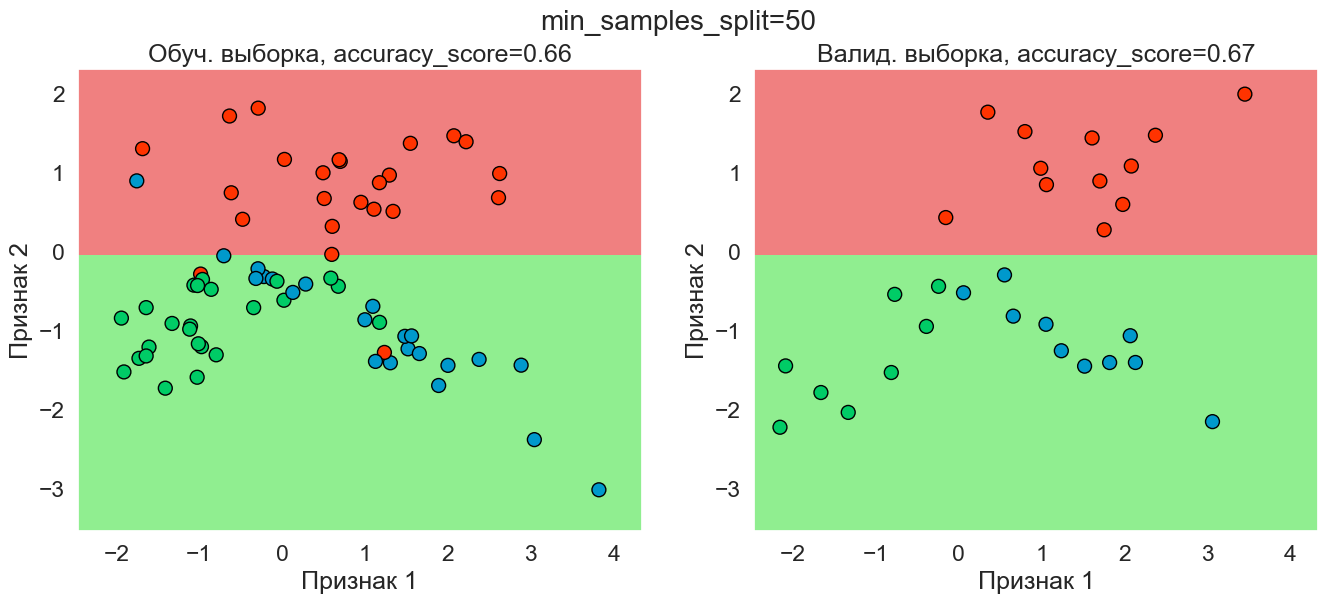

In [21]:
estimator = DecisionTreeClassifier(
    random_state=42, min_samples_leaf=1, min_samples_split=50
)
plot_decision_surface(
    estimator, X_train, y_train, 
    X_valid, y_valid, title='min_samples_split=50'
)

**Вывод.**

При изменении значения `min_samples_split` происходит ситуация, аналогичной случаю, когда мы варьируем `min_samples_leaf`. И здесь наблюдается следующая закономерность: с увеличением значения `min_samples_split` качество 
* на обучающей выборке падает, 
* на валидационной выборке &mdash; до некоторого момента возрастает. 

Кроме того, с увеличением `min_samples_split` разделяющая поверхность становится проще.

#### Другие параметры.

Кроме того, обратите внимание на другие параметры класса `DecisionTreeClassifier` в `sklearn`:

1. `criterion` &mdash; критерий, по которому происходит разбиение вершины дерева. Стандартные критерии для классификации &mdash; критерий Джини (`giny`) и энтропийный критерий (`entropy`), при этом `giny` &mdash; критерий по умолчанию.  В этом ноутбуке мы брали для классификации критерий по умолчанию.  Более подробную информацию по критериям можно найти в <a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html" target="_blank">документации sklearn</a>.


2. `splitter` &mdash; способ разбиения вершины решающего дерева. Есть два возможных варианта: `best` и `random`. В первом случае рассматриваются все возможные способы разбить вершину дерева на две и берётся тот из них, значение критерия для которого оптимально. При `splitter=random` берётся несколько случайных возможных разбиений и среди них выбирается то, значение критерия для которого оптимально.


3. `max_features` &mdash; максимальное количество признаков, которые могут быть перебраны при разбиении вершины дерева. Перед каждым разбиением вершины генерируется выборка из `min(d, max_features)` случайных признаков (`d` &mdash; количество признаков в датасете) и только эти признаки рассматриваются как разделяющие.


4. `min_impurity_decrease` &mdash; минимальное значение уменьшения взвешенного критерия неопределенности (`impurity`), чтобы можно было разбить выборку в данной вершине.


Об остальных гиперпараметрах класса решающего дерева в `sklearn` можно прочитать в <a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html" target="_blank">документации</a>.

### 2. Регрессия с использованием решающего дерева

В регрессии будем использовать все те же параметры разбиения. Но в качестве критерия неопределенности (параметр `criterion`) используются `squared_error`, `friedman_mse`, `absolute_error`, причём `squared_error` &mdash; критерий по умолчанию..


Сгенерируем регрессионные данные. Принцип работы функции такой же, как и для генерации датасета для классификации, что мы разбирали выше.

In [22]:
data, target = datasets.make_regression(
    n_features=2, n_informative=2, random_state=3, n_samples=200
)

Визуализируем. Отклик показан цветом точки.

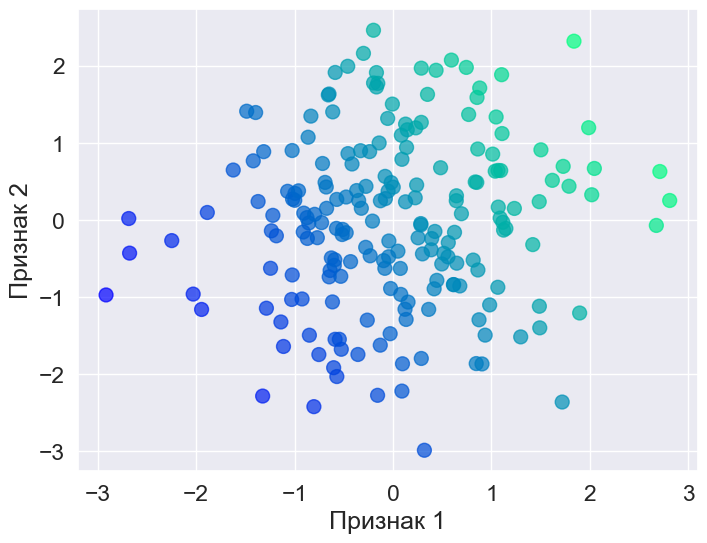

In [23]:
plt.figure(figsize=(8, 6))
grid_x1 = data[:, 0]
grid_x2 = data[:, 1]
plt.scatter(grid_x1, grid_x2, c=target, s=100, alpha=0.7, cmap='winter')
plt.xlabel('Признак 1'), plt.ylabel('Признак 2');

Разобьём данные на обучение и валидацию.

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(
    data, target, random_state=42
)

Исследуем зависимость качества работы регрессионного дерева в зависимости от максимально возможной его глубины.  

Цветом поверхности обозначается ответ в листе. Но для регрессит это не класс, а некоторое число.

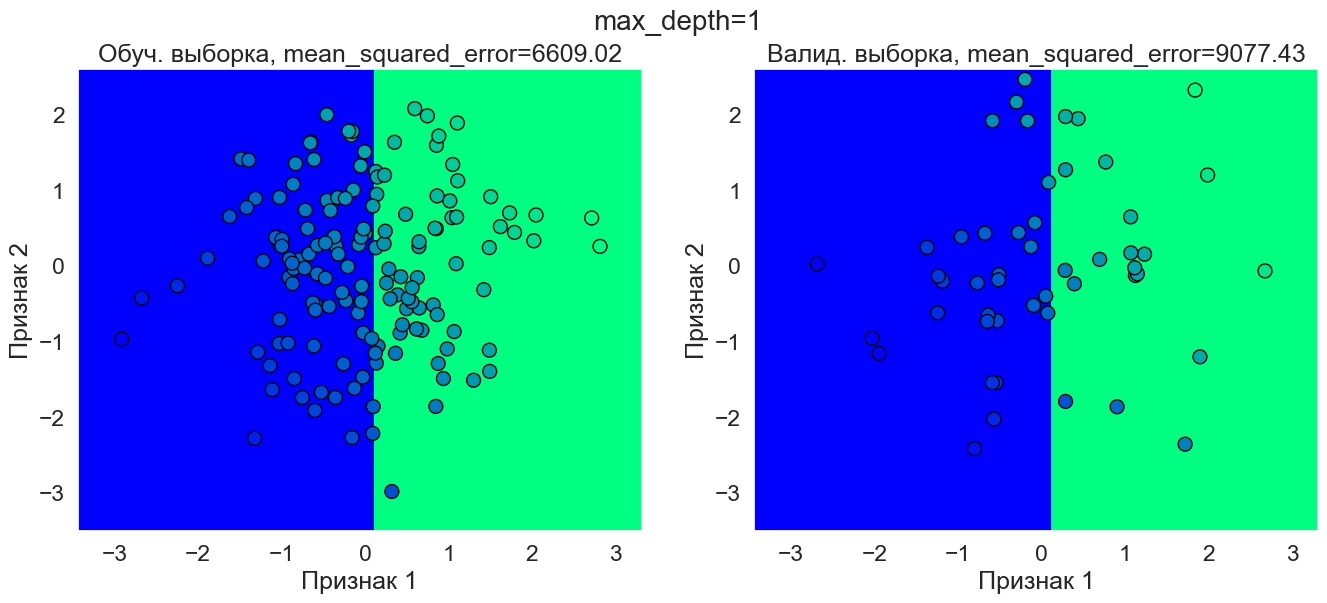

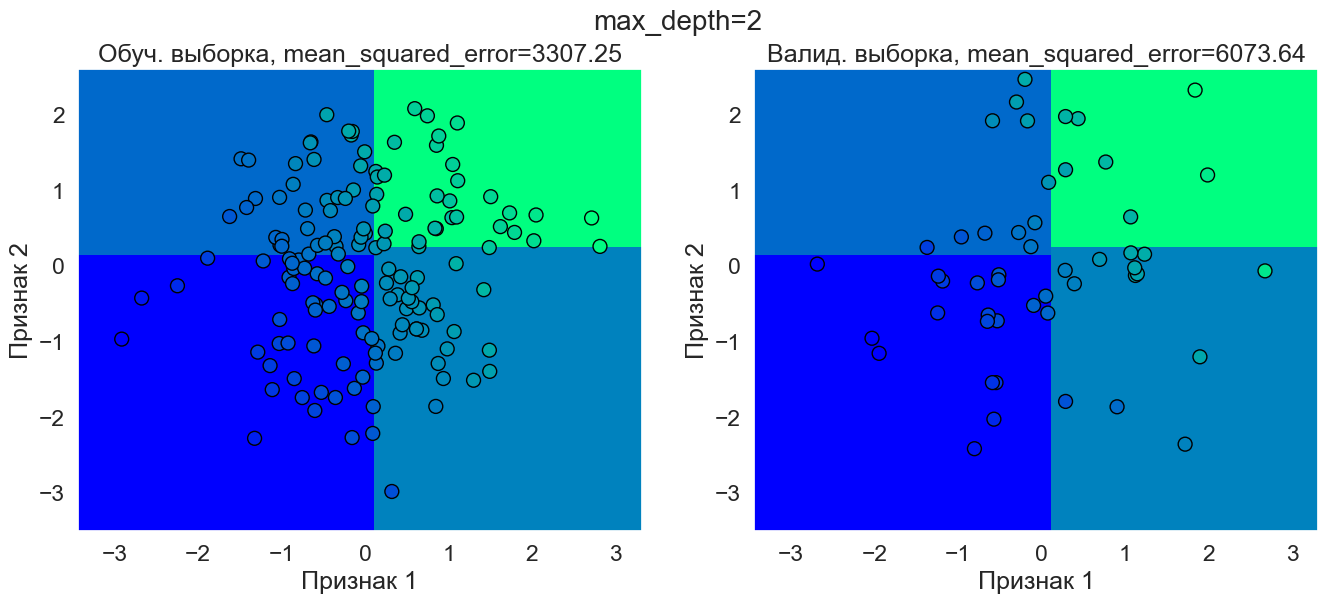

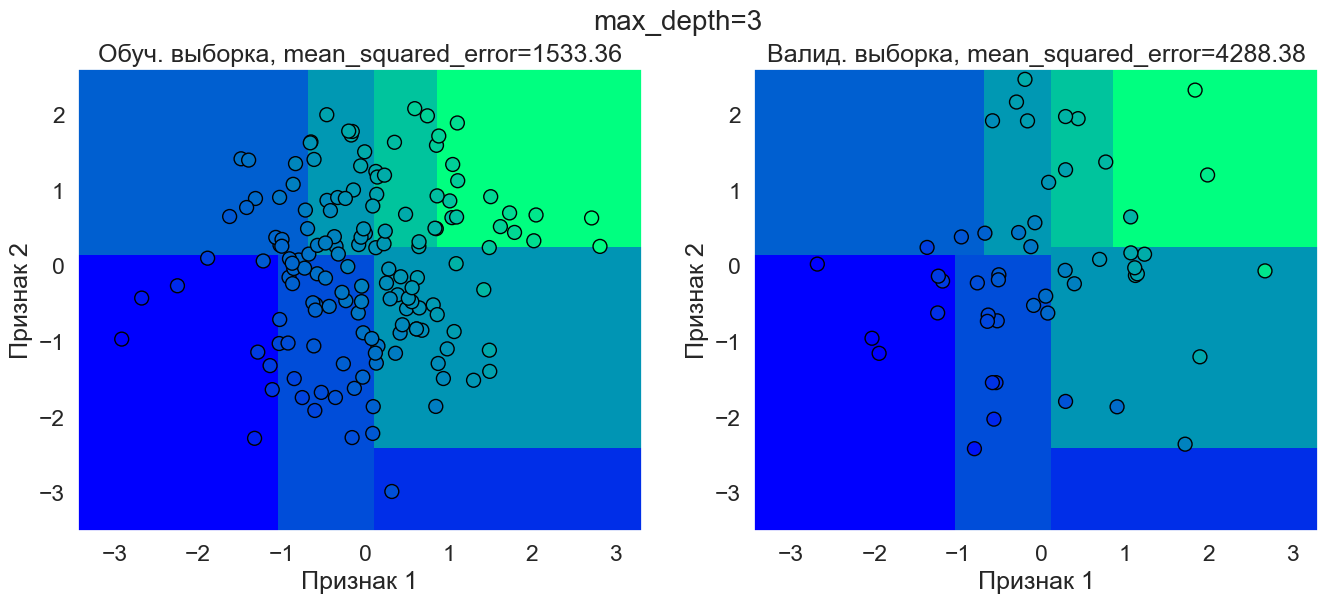

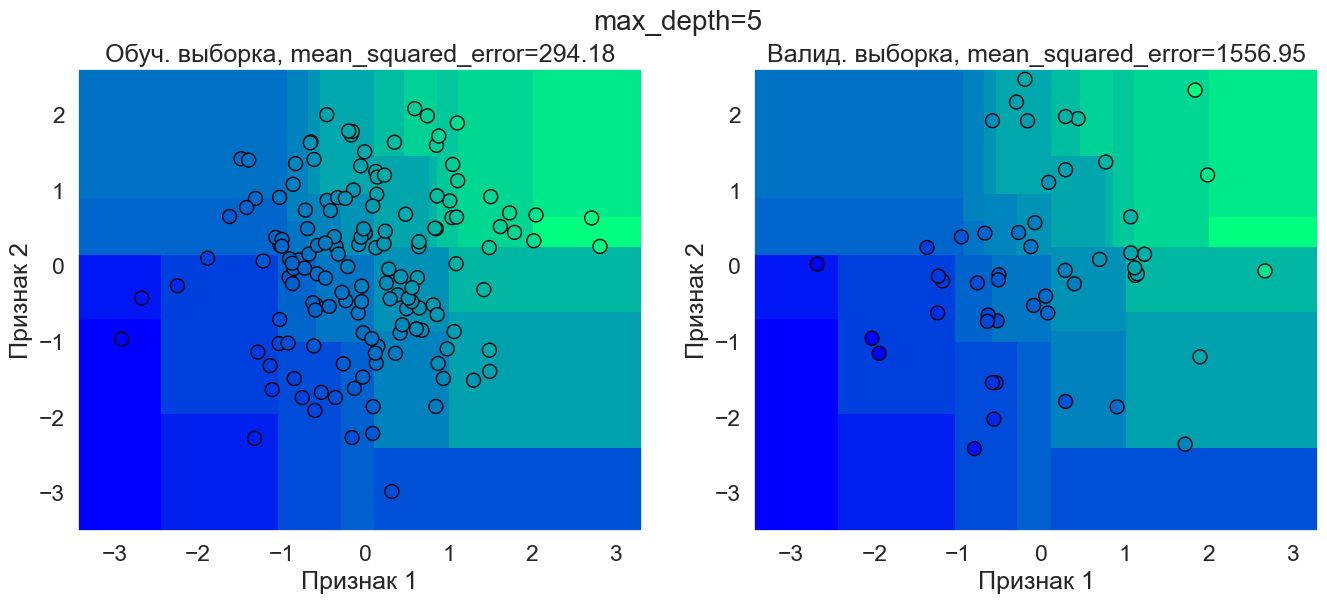

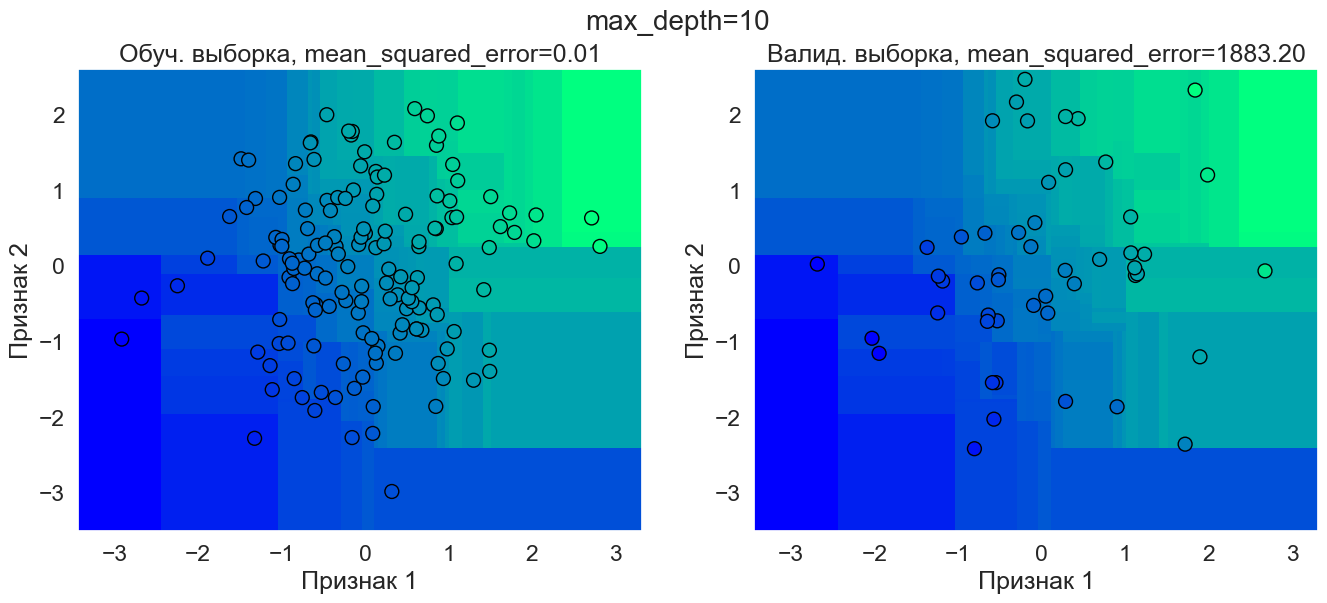

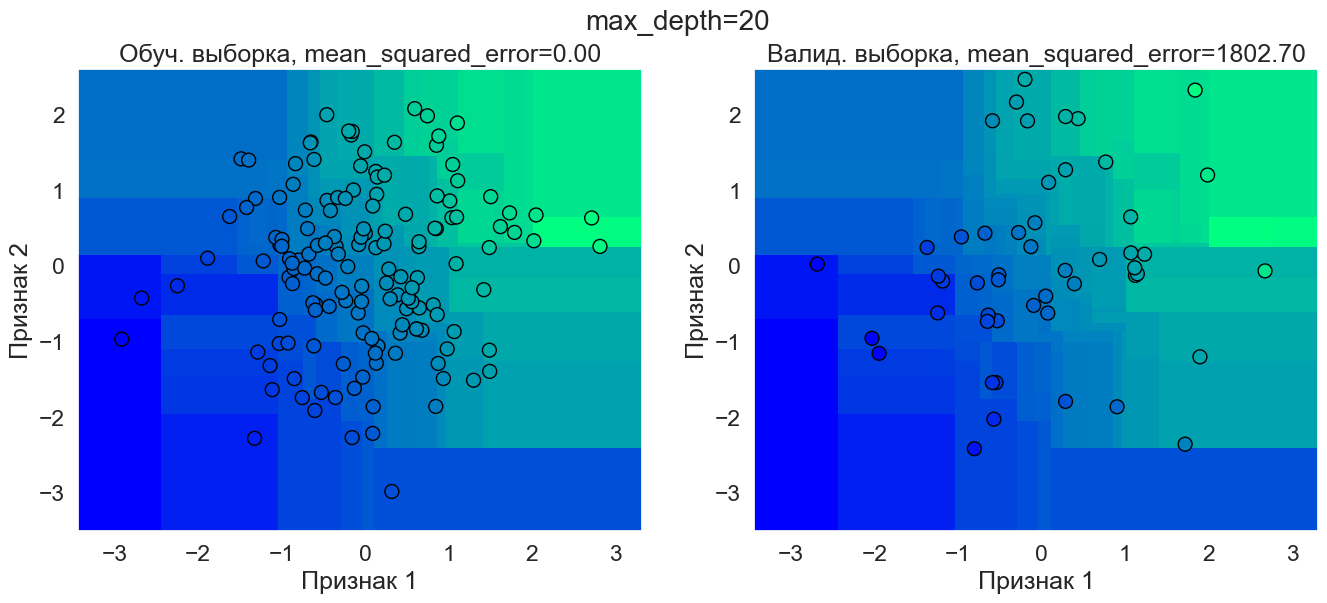

In [25]:
for max_depth in [1, 2, 3, 5, 10, 20]:
    estimator = DecisionTreeRegressor(random_state=42, max_depth=max_depth)
    plot_decision_surface(
        estimator, X_train, y_train, X_valid, y_valid, 
        title='max_depth={}'.format(max_depth), colors='winter',
        light_colors='winter', metric=mean_squared_error
    )

Для решения задачи регрессии недостаточно малой глубины дерева, но как в задаче классификации при слишком большой глубине может происходить переобучение. Регрессионная зависимость, восстанавливаемая деревом, выглядит сильно сложно.

### 3. Визуализация решающих деревьев

Посмотрим, как можно визуализировать структуру решающего дерева, в этом нам поможет библиотека `graphviz`.

Для установки библиотеки через pip:
```bash
pip install graphviz
```

Для установки библиотеки через conda:
```bash
conda install -c conda-forge python-graphviz 
```

В качестве данных возьмём [датасет с Kaggle](https://www.kaggle.com/crawford/1000-cameras-dataset/download) по определению цены камеры по её имеющимся характеристикам.

К её характеристикам относятся:

* `Release date` — дата выпуска,

* `Max resolution` — максимальное разрешение,

* `Low resolution` — нижнее разрешение,

* `Effective pixels` — число эффективных пикселей, 

* `Zoom wide (W)` — ширина зума,

* `Zoom tele (T)` — телезум,

* `Normal focus range` — нормальный фокусный диапазон,

* `Macro focus range` — макрофокусный диапазон,

* `Storage included` — встроенный объём памяти,

* `Weight (inc. batteries)` — вес,

* `Dimensions` — габариты.

Для того, чтобы деревья не получались слишком широкими, будем их обучать на небольшой части датасета

In [27]:
camera_df = pd.read_csv('camera_dataset.csv')[:100]
camera_df = camera_df.drop('Model', axis=1)

print(camera_df.shape)
camera_df.head()

(100, 12)


,Release date,Max resolution,Low resolution,Effective pixels,Zoom wide (W),Zoom tele (T),Normal focus range,Macro focus range,Storage included,Weight (inc. batteries),Dimensions,Price
0,1997,1024.0,640.0,0.0,38.0,114.0,70.0,40.0,4.0,420.0,95.0,179.0
1,1998,1280.0,640.0,1.0,38.0,114.0,50.0,0.0,4.0,420.0,158.0,179.0
2,2000,640.0,0.0,0.0,45.0,45.0,0.0,0.0,2.0,0.0,0.0,179.0
3,1999,1152.0,640.0,0.0,35.0,35.0,0.0,0.0,4.0,0.0,0.0,269.0
4,1999,1152.0,640.0,0.0,43.0,43.0,50.0,0.0,40.0,300.0,128.0,1299.0


Выделим отдельно признаки и таргет

In [28]:
X, y = camera_df.loc[:, camera_df.columns != 'Price'], camera_df['Price']

Напишем функцию визуализации дерева 

In [29]:
def get_graphviz_graph(decision_tree_regressor):
    '''
    Функция для обучения решающего дерева и построения
    по нему графа graphviz для визуализации
    '''
    
    decision_tree_regressor.fit(X, y)
    dot_data = export_graphviz(
        decision_tree_regressor, out_file=None, 
        feature_names=X.columns, 
        filled=True, rounded=True, special_characters=True
    )  
    return graphviz.Source(dot_data)  

Визуализируем деревья для разной глубины

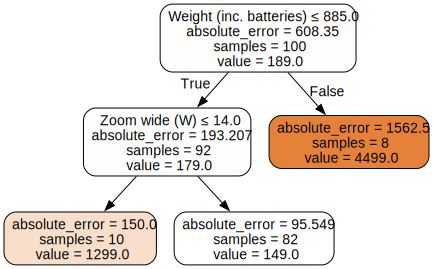

In [31]:
camera_regressor = DecisionTreeRegressor(
    criterion='absolute_error', max_depth=2, min_samples_split=10
)
graph = get_graphviz_graph(camera_regressor)
graph

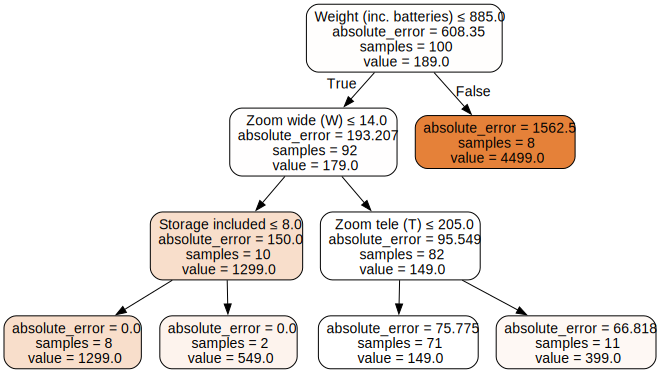

In [32]:
camera_regressor = DecisionTreeRegressor(
    criterion='absolute_error', max_depth=3, min_samples_split=10
)
graph = get_graphviz_graph(camera_regressor)
graph

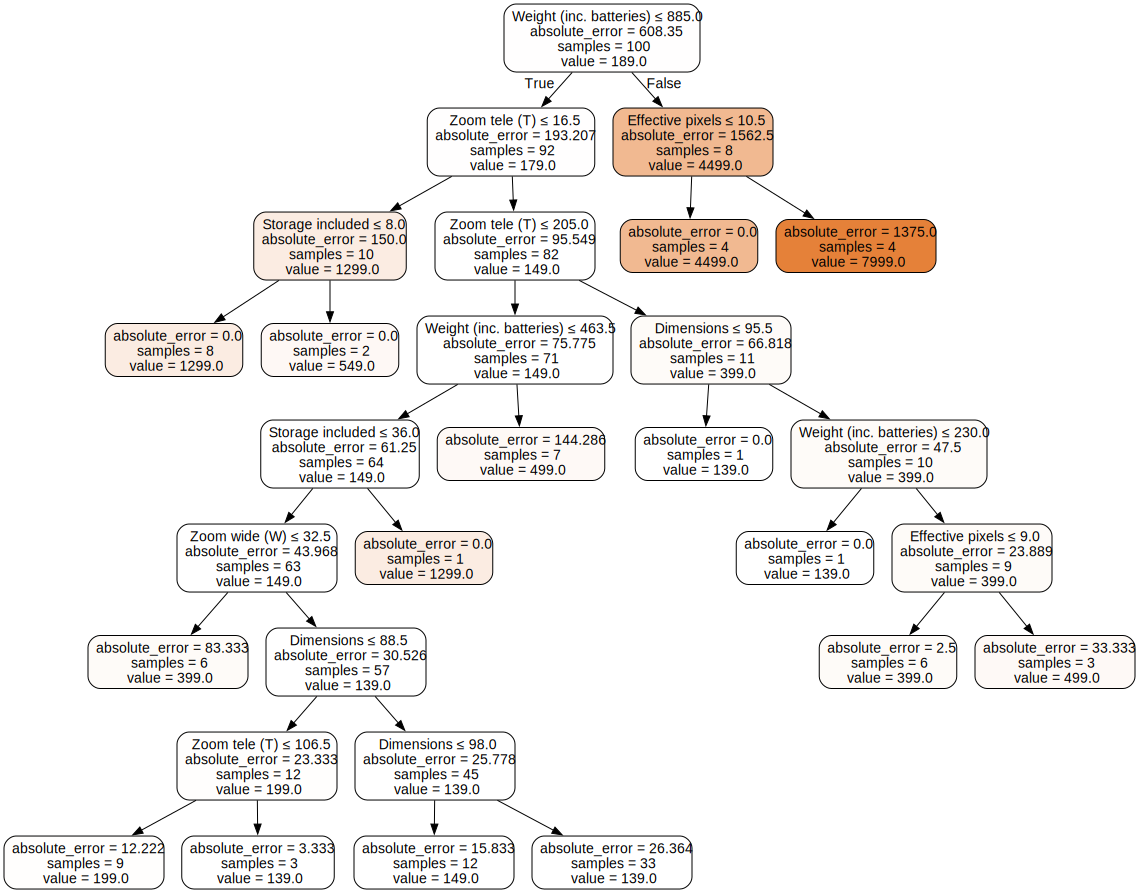

In [33]:
camera_regressor = DecisionTreeRegressor(
    criterion='absolute_error', max_depth=8, min_samples_split=8
)
graph = get_graphviz_graph(camera_regressor)
graph

По построенной визуализации дерева можно увидеть, что большая часть разбиений вершин вполне соотносится со здравым смыслом и логикой принятия решений человеком. Например, чем больше zoom камеры, тем больше должна быть цена при прочих равных или чем больше встроенной памяти имеет камера, тем больше должна быть её цена.